In [1]:
!pip install opendatasets --upgrade --quiet


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#https://www.kaggle.com/datasets/jakeshbohaju/brain-tumor

In [3]:
# get the data from
import opendatasets as od

dataset_url = 'https://www.kaggle.com/datasets/preetviradiya/brian-tumor-dataset'
od.download(dataset_url)


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: muhammadikhalas
Your Kaggle Key: ··········


100%|██████████| 107M/107M [00:01<00:00, 84.5MB/s]


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import shutil
import glob

In [5]:
ROOT_DIR = "/content/brian-tumor-dataset/Brain Tumor Data Set/Brain Tumor Data Set"
number_of_images = {}

for dir in os.listdir(ROOT_DIR):
    number_of_images[dir] = len(os.listdir(os.path.join(ROOT_DIR, dir)))



In [6]:
number_of_images.items()

dict_items([('Brain Tumor', 2513), ('Healthy', 2087)])

# we will split the data such that
* 70 % for Train Data
* 15 % for Validation
* 15 % for testing

In [7]:
def dataFolder(p, split):
  # we will create a train folder

  if not os.path.exists("./"+p):
    os.mkdir("./"+p)

    for dir in os.listdir(ROOT_DIR):
     os.makedirs("./"+p+"/"+dir)

     for img in np.random.choice(a = os.listdir(os.path.join(ROOT_DIR, dir)),
                                size = (math.floor(split*number_of_images[dir])-10),
                                replace=False):
       O = os.path.join(ROOT_DIR, dir, img) #path
       D = os.path.join("./"+p,dir)
       shutil.copy(O,D)
       os.remove(O)

  else:
    print(f"{p} Folder exsist")


In [8]:
dataFolder("train", 0.7)




In [9]:
dataFolder("val", 0.15)

In [10]:
dataFolder("test", 0.15)

In [11]:
number_of_images = {}
for dir in os.listdir(ROOT_DIR):
  number_of_images[dir] = len(os.listdir(os.path.join(ROOT_DIR, dir)))

number_of_images.items()

dict_items([('Brain Tumor', 32), ('Healthy', 31)])

#Model Build

In [12]:
!pip install tensorflow



In [13]:
import tensorflow as tf
import keras
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAvgPool2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator


In [14]:
# CNN Model

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape= (224,224,3)))

model.add(Conv2D(filters=36, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Dropout(rate=0.25))

model.add(Flatten())
model.add(Dense(units=64, activation = 'relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(units=1, activation='sigmoid'))


In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 36)      5220      
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 36)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 64)      20800     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 52, 52, 128)       7

In [16]:
model.compile(optimizer='adam', loss=keras.losses.binary_crossentropy, metrics=['accuracy'])

# Preparing our data using Data Generator

In [17]:
def preprocessingImages1(path):
  """

  imput : Path
  output : Pre processed images
  """

  image_data = ImageDataGenerator(zoom_range=0.2, shear_range=0.2, rescale=1/255, horizontal_flip=True)
  image = image_data.flow_from_directory(directory = path, target_size = (224, 224), batch_size = 32, class_mode='binary')

  return image

In [ ]:
path = "/content/train"
train_data = preprocessingImages1(path)

In [ ]:
def preprocessingImages2(path):
  """

  imput : Path
  output : Pre processed images
  """

  image_data = ImageDataGenerator(rescale=1/255)
  image = image_data.flow_from_directory(directory = path, target_size = (224, 224), batch_size = 32, class_mode='binary')

  return image

In [ ]:
path = "/content/test"
test_data = preprocessingImages2(path)

Found 669 images belonging to 2 classes.


In [ ]:
path = "/content/val"
val_data = preprocessingImages2(path)

Found 669 images belonging to 2 classes.


In [ ]:
# Assuming you have this dictionary already populated
train_data.class_indices = {'brain_tumor': 0, 'healthy': 1}

# Reverse the dictionary
train_data.class_indices = {v: k for k, v in train_data.class_indices.items()}

# Now, train_data.class_indices will have the reversed mapping
train_data.class_indices

{0: 'brain_tumor', 1: 'healthy'}

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

# early stopping
es = EarlyStopping(monitor="val_accuracy", min_delta=0.01, patience=3, verbose=1, mode='auto')

# model checkpoints
mc = ModelCheckpoint(monitor="val_accuracy",filepath="./bestmodel.h5", verbose=1, save_best_only=True,  mode='auto')

cd = [es, mc]

###Model Training


In [ ]:
hs = model.fit_generator(generator = train_data,
                         steps_per_epoch=8, epochs=30,
                         verbose=1, validation_data=val_data,
                         validation_steps=16, callbacks=cd)


Epoch 1/10
2/2 [==============================] - ETA: 0s - loss: 0.9664 - accuracy: 0.4531 
Epoch 1: val_accuracy improved from -inf to 0.54883, saving model to ./bestmodel.h5
2/2 [==============================] - 17s 3s/step - loss: 0.9664 - accuracy: 0.4531 - val_loss: 0.9294 - val_accuracy: 0.5488
Epoch 2/10
2/2 [==============================] - ETA: 0s - loss: 0.8892 - accuracy: 0.5625
Epoch 2: val_accuracy improved from 0.54883 to 0.55469, saving model to ./bestmodel.h5
2/2 [==============================] - 3s 2s/step - loss: 0.8892 - accuracy: 0.5625 - val_loss: 0.6856 - val_accuracy: 0.5547
Epoch 3/10
2/2 [==============================] - ETA: 0s - loss: 0.7634 - accuracy: 0.3594
Epoch 3: val_accuracy did not improve from 0.55469
2/2 [==============================] - 3s 3s/step - loss: 0.7634 - accuracy: 0.3594 - val_loss: 0.6924 - val_accuracy: 0.4629
Epoch 4/10
2/2 [==============================] - ETA: 0s - loss: 0.6848 - accuracy: 0.5469
Epoch 4: val_accuracy did not 

In [ ]:
# model Graphical Interpretation

h = hs.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

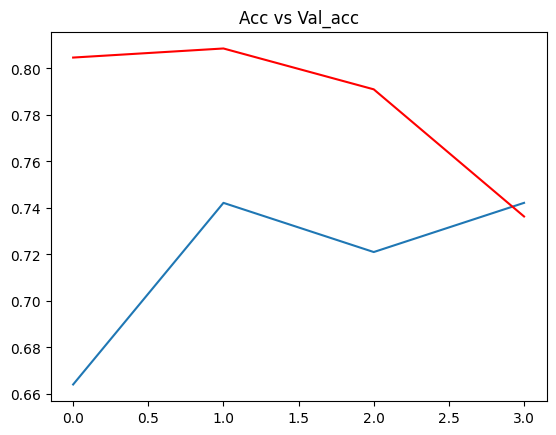

In [ ]:
import matplotlib.pyplot as plt

plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'], c="red")

plt.title("Acc vs Val_acc")
plt.show()

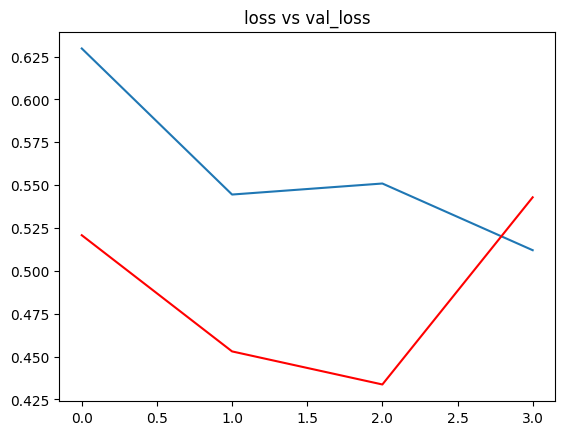

In [ ]:
import matplotlib.pyplot as plt

plt.plot(h['loss'])
plt.plot(h['val_loss'], c="red")

plt.title("loss vs val_loss")
plt.show()

In [ ]:
# model Accuracy

from keras.models import load_model

model = load_model("/content/bestmodel.h5")



###Model Accuracy


In [ ]:
acc = model.evaluate_generator(test_data)[1]

print(f"the accuracy of our model is {acc*100} %")

the accuracy of our model is 80.55964708328247 %


In [ ]:
from keras.preprocessing.image import load_img, img_to_array

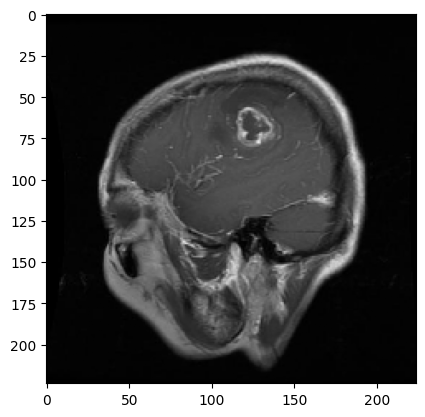

1/1 [==============================] - 0s 43ms/step
[[0.51422054]]
The MRI is having a Tumor


In [ ]:
path = "/content/brian-tumor-dataset/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (184).jpg"

img = load_img(path, target_size=(224,224))
input_arr = img_to_array(img) / 255

plt.imshow(input_arr)
plt.show()

input_arr = np.expand_dims(input_arr, axis=0)

# Assuming 'model' is your neural network model
# Use 'predict' to get class probabilities
pred = model.predict(input_arr)
print(pred)
if pred >= 0.5:
   print("The MRI is having a Tumor")

else:
   print("The MRI is not having a Tumor")




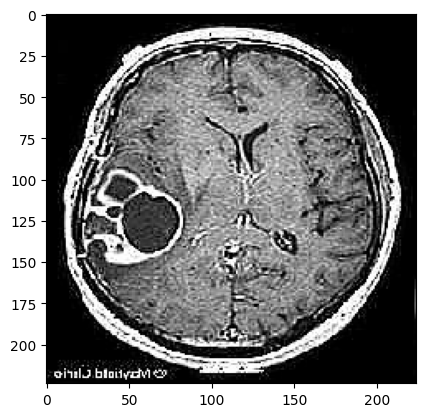

1/1 [==============================] - 0s 65ms/step
The MRI is not having a Tumor


In [ ]:
path = "/content/brian-tumor-dataset/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (2077).jpg"

img = load_img(path, target_size=(224,224))
input_arr = img_to_array(img) / 255

plt.imshow(input_arr)
plt.show()

input_arr = np.expand_dims(input_arr, axis=0)

# Assuming 'model' is your neural network model
# Use 'predict' to get class probabilities
prob = model.predict(input_arr)[0][0]

if prob >= 0.5:  # If probability is greater than or equal to 0.5
    print("The MRI is having a Tumor")
else:
    print("The MRI is not having a Tumor")


1/1 [==============================] - 0s 104ms/step


0
The MRI is not having a Tumor


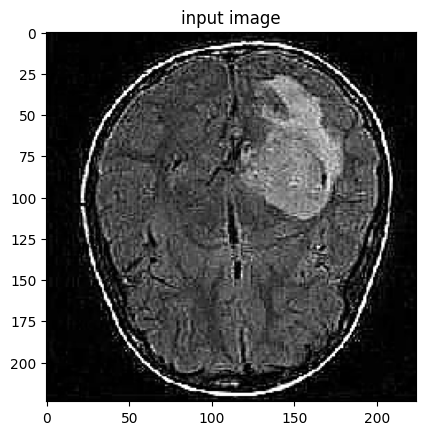

In [ ]:
from keras.preprocessing import image

path = "/content/brian-tumor-dataset/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1852).jpg"

img = load_img(path, target_size=(224,224))
img = image.load_img(path, target_size=(224,224))

i = image.img_to_array(img)/225
input_arr = np.array([i])

input_arr.shape

pred = np.argmax(model.predict(input_arr))
print(pred)
if pred == 0:
  print("The MRI is not having a Tumor")
else:
  print("The MRI is having a Tumor")



# to display the image
plt.imshow(input_arr[0])
plt.title("input image")
plt.show()


In [ ]:
import tensorflow as tf

print(tf.__version__)


2.12.0
